# Custom TransferLearning using MobileNetV2

In [ ]:
#!pip install sklearn
#!pip install imutils

In [1]:
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Empezamos el entrenamiento

In [3]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pyimagesearch.preprocessing import ImageToArrayPreprocessor
from pyimagesearch.preprocessing import AspectAwarePreprocessor
from pyimagesearch.datasets import SimpleDatasetLoader

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from imutils import paths
import numpy as np
import os
import cv2

# Leemos la data

In [4]:
img_size = 224
path_train = 'data_' + str(img_size) + '/train'
path_validation = 'data_' + str(img_size) + '/validation'

In [5]:
imagePaths_train = list(paths.list_images(path_train))
imagePaths_validation = list(paths.list_images(path_validation))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths_train]
classNames = [str(x) for x in np.unique(classNames)]

print("etiquetas del entrenamiento")
print(classNames)

#Códificando las etiquetas en númerops
print("codificando etiquetas")
le = LabelEncoder()
classNames_ids = le.fit_transform(classNames)
print(classNames_ids)

etiquetas del entrenamiento
['10', '100', '20', '200', '50']
codificando etiquetas
[0 1 2 3 4]


In [6]:
iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessors=[iap])

print('Cargando data para el entrenamiento')
data_train, labels_train = sdl.load(imagePaths_train, verbose=5000)

print('Cargando data para la validación')
data_validation, labels_validation = sdl.load(imagePaths_validation, verbose=500)

print('Binarizando los labels')
labels_train = LabelBinarizer().fit_transform(labels_train)
labels_validation = LabelBinarizer().fit_transform(labels_validation)

print('Carga terminada')


Cargando data para el entrenamiento
[INFO] processed 5000/12000
[INFO] processed 10000/12000
Cargando data para la validación
[INFO] processed 500/1515
[INFO] processed 1000/1515
[INFO] processed 1500/1515
Binarizando los labels
Carga terminada


# Creando el modelo base

In [7]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size,img_size,3)
)

# Congelamos las capas para el entrenamiento

In [8]:
for layer in base_model.layers:
    layer.trainable = True

# Creamos la nueva cabecera

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense

# Creamos varios modelos para luego realizar un ensamblaje

In [13]:
path_ensembles = 'ensembles_MobileNetV2'
batch_size = 32
epochs = 100
num_models = 6 #número de modelos a crear

# Entrenamiento

In [11]:
print('Normalizando los datos')
data_train = data_train.astype("float") / 255.0
data_validation = data_validation.astype("float") / 255.0

print('Generando la data para el entrenamiento')
aug_train = ImageDataGenerator()
aug_train.fit(data_train)
train_generator = aug_train.flow(data_train, labels_train, batch_size=batch_size)

aug_validation = ImageDataGenerator()
aug_validation.fit(data_validation)
validation_generator = aug_validation.flow(data_validation, labels_validation, batch_size=batch_size)

print('Terminado')

Normalizando los datos
Generando la data para el entrenamiento
Terminado


In [14]:
for i in np.arange(0, num_models):
    
    optimizer = Adam(learning_rate=0.0001)
    loss = 'categorical_crossentropy'
    metrics=["accuracy"]
    
    print("[INFO] entrenando el modelo {}/{}".format(i + 1, num_models))
    model = tf.keras.Sequential([
                                  base_model,
                                  Flatten(),
                                  Dense(1024, activation='relu'),
                                  Dense(1024, activation='relu'),
                                  Dense(1024, activation='relu'),
                                  Dropout(0.2),
                                  Dense(512, activation='relu'),
                                  Dense(512, activation='relu'),
                                  Dense(512, activation='relu'),
                                  Dropout(0.2),
                                  Dense(128, activation='relu'),
                                  Dense(128, activation='relu'),
                                  Dense(128, activation='relu'),
                                  Dropout(0.2),
                                  Dense(64, activation='relu'),
                                  Dense(32, activation='relu'),
                                  Dense(len(classNames_ids), activation='softmax')
                                ])
    
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    
    #entrenando el modelo
    history = model.fit_generator(train_generator,
                                  steps_per_epoch=len(train_generator),
                                  validation_data=validation_generator,
                                  epochs = epochs,
                                  verbose = 1)
    
    #guardando el modelo
    p = [path_ensembles, "model_{}.model".format(i)]
    model.save(os.path.sep.join(p))
    
    #evaluando el modelo
    predictions = model.predict(data_validation, batch_size=batch_size)
    report = classification_report(labels_validation.argmax(axis=1),
                                    predictions.argmax(axis=1),
                                    target_names=classNames)
    
    #guardando el reporte
    p = [path_ensembles, "model_{}.txt".format(i)]
    f = open(os.path.sep.join(p), "w")
    f.write(report)
    f.close()
    
    #creando un plot de los entrenamientos
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
                               
    p = [path_ensembles, "model_{}.png".format(i)]
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.plot(acc, label="Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title("Training Loss and Accuracy for model {}".format(i))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig(os.path.sep.join(p))
    plt.close()

[INFO] entrenando el modelo 1/6
Epoch 1/100
375/375 [==============================] - 55s 146ms/step - loss: 0.0600 - accuracy: 0.9795 - val_loss: 10.5057 - val_accuracy: 0.4337
Epoch 2/100
375/375 [==============================] - 56s 148ms/step - loss: 0.0173 - accuracy: 0.9975 - val_loss: 5.5259 - val_accuracy: 0.5300
Epoch 3/100
375/375 [==============================] - 55s 145ms/step - loss: 0.0039 - accuracy: 0.9994 - val_loss: 3.9609 - val_accuracy: 0.6007
Epoch 4/100
375/375 [==============================] - 53s 143ms/step - loss: 0.0183 - accuracy: 0.9980 - val_loss: 6.1268 - val_accuracy: 0.5604
Epoch 5/100
375/375 [==============================] - 54s 144ms/step - loss: 0.0268 - accuracy: 0.9979 - val_loss: 6.6644 - val_accuracy: 0.5327
Epoch 6/100
375/375 [==============================] - 54s 145ms/step - loss: 0.0221 - accuracy: 0.9964 - val_loss: 3.2658 - val_accuracy: 0.6264
Epoch 7/100
375/375 [==============================] - 54s 144ms/step - loss: 0.0242 - accu

375/375 [==============================] - 54s 144ms/step - loss: 0.0028 - accuracy: 0.9998 - val_loss: 2.5740 - val_accuracy: 0.6020
Epoch 55/100
375/375 [==============================] - 54s 144ms/step - loss: 1.4964e-04 - accuracy: 1.0000 - val_loss: 3.1704 - val_accuracy: 0.6013
Epoch 56/100
375/375 [==============================] - 54s 143ms/step - loss: 0.0068 - accuracy: 0.9995 - val_loss: 1.7974 - val_accuracy: 0.6746
Epoch 57/100
375/375 [==============================] - 54s 145ms/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 4.9202 - val_accuracy: 0.5716
Epoch 58/100
375/375 [==============================] - 54s 144ms/step - loss: 0.0063 - accuracy: 0.9998 - val_loss: 5.8598 - val_accuracy: 0.5604
Epoch 59/100
375/375 [==============================] - 54s 144ms/step - loss: 2.7670e-04 - accuracy: 0.9999 - val_loss: 3.6880 - val_accuracy: 0.6046
Epoch 60/100
375/375 [==============================] - 54s 144ms/step - loss: 8.6352e-05 - accuracy: 1.0000 - val_loss: 3.

Epoch 7/100
375/375 [==============================] - 53s 143ms/step - loss: 0.0034 - accuracy: 0.9995 - val_loss: 7.0375 - val_accuracy: 0.5782
Epoch 8/100
375/375 [==============================] - 54s 143ms/step - loss: 8.8970e-05 - accuracy: 1.0000 - val_loss: 6.5462 - val_accuracy: 0.5967
Epoch 9/100
375/375 [==============================] - 53s 142ms/step - loss: 8.2755e-05 - accuracy: 1.0000 - val_loss: 6.0604 - val_accuracy: 0.6046
Epoch 10/100
375/375 [==============================] - 53s 141ms/step - loss: 0.0157 - accuracy: 0.9986 - val_loss: 9.0019 - val_accuracy: 0.4620
Epoch 11/100
375/375 [==============================] - 53s 142ms/step - loss: 0.0123 - accuracy: 0.9991 - val_loss: 7.3149 - val_accuracy: 0.5432
Epoch 12/100
375/375 [==============================] - 54s 143ms/step - loss: 0.0064 - accuracy: 0.9995 - val_loss: 3.9126 - val_accuracy: 0.5861
Epoch 13/100
375/375 [==============================] - 54s 143ms/step - loss: 0.0242 - accuracy: 0.9990 - val_lo

Epoch 62/100
375/375 [==============================] - 54s 143ms/step - loss: 4.8466e-05 - accuracy: 1.0000 - val_loss: 5.5053 - val_accuracy: 0.5743
Epoch 63/100
375/375 [==============================] - 53s 143ms/step - loss: 0.0343 - accuracy: 0.9993 - val_loss: 15.1943 - val_accuracy: 0.4508
Epoch 64/100
375/375 [==============================] - 54s 143ms/step - loss: 0.0108 - accuracy: 0.9993 - val_loss: 10.3092 - val_accuracy: 0.5373
Epoch 65/100
375/375 [==============================] - 53s 142ms/step - loss: 0.0176 - accuracy: 0.9997 - val_loss: 5.2585 - val_accuracy: 0.5393
Epoch 66/100
375/375 [==============================] - 53s 142ms/step - loss: 0.0032 - accuracy: 0.9996 - val_loss: 5.1549 - val_accuracy: 0.5439
Epoch 67/100
375/375 [==============================] - 54s 144ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 2.7267 - val_accuracy: 0.6119
Epoch 68/100
375/375 [==============================] - 54s 143ms/step - loss: 0.0019 - accuracy: 0.9999 - val_l

375/375 [==============================] - 54s 143ms/step - loss: 1.4119e-04 - accuracy: 1.0000 - val_loss: 8.5006 - val_accuracy: 0.5934
Epoch 15/100
375/375 [==============================] - 54s 143ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 9.0024 - val_accuracy: 0.6013
Epoch 16/100
375/375 [==============================] - 54s 143ms/step - loss: 1.5636e-04 - accuracy: 0.9999 - val_loss: 6.8393 - val_accuracy: 0.6099
Epoch 17/100
375/375 [==============================] - 54s 144ms/step - loss: 2.3534e-04 - accuracy: 0.9999 - val_loss: 6.2812 - val_accuracy: 0.5974
Epoch 18/100
375/375 [==============================] - 52s 140ms/step - loss: 5.0598e-04 - accuracy: 0.9999 - val_loss: 13.3928 - val_accuracy: 0.5617
Epoch 19/100
375/375 [==============================] - 53s 140ms/step - loss: 3.6849e-04 - accuracy: 0.9999 - val_loss: 13.1814 - val_accuracy: 0.5703
Epoch 20/100
375/375 [==============================] - 54s 144ms/step - loss: 0.0025 - accuracy: 0.9996 - va

Epoch 69/100
375/375 [==============================] - 54s 143ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 7.1099 - val_accuracy: 0.6284
Epoch 70/100
375/375 [==============================] - 53s 142ms/step - loss: 0.0069 - accuracy: 0.9989 - val_loss: 10.4129 - val_accuracy: 0.5987
Epoch 71/100
375/375 [==============================] - 54s 143ms/step - loss: 0.0088 - accuracy: 0.9995 - val_loss: 3.6986 - val_accuracy: 0.6462
Epoch 72/100
375/375 [==============================] - 54s 143ms/step - loss: 1.9408e-04 - accuracy: 1.0000 - val_loss: 4.4540 - val_accuracy: 0.6515
Epoch 73/100
375/375 [==============================] - 54s 143ms/step - loss: 5.2916e-05 - accuracy: 1.0000 - val_loss: 4.6202 - val_accuracy: 0.6568
Epoch 74/100
375/375 [==============================] - 54s 143ms/step - loss: 1.1426e-05 - accuracy: 1.0000 - val_loss: 4.5955 - val_accuracy: 0.6601
Epoch 75/100
375/375 [==============================] - 54s 143ms/step - loss: 1.8809e-04 - accuracy: 0.9

375/375 [==============================] - 53s 142ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 10.0540 - val_accuracy: 0.5663
Epoch 22/100
375/375 [==============================] - 53s 142ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 9.1834 - val_accuracy: 0.5538
Epoch 23/100
375/375 [==============================] - 54s 143ms/step - loss: 0.0113 - accuracy: 0.9993 - val_loss: 7.2032 - val_accuracy: 0.5003
Epoch 24/100
375/375 [==============================] - 54s 143ms/step - loss: 9.4169e-05 - accuracy: 1.0000 - val_loss: 6.9526 - val_accuracy: 0.5307
Epoch 25/100
375/375 [==============================] - 53s 142ms/step - loss: 2.7183e-04 - accuracy: 0.9999 - val_loss: 8.1053 - val_accuracy: 0.5320
Epoch 26/100
375/375 [==============================] - 53s 142ms/step - loss: 9.8086e-07 - accuracy: 1.0000 - val_loss: 8.6475 - val_accuracy: 0.5439
Epoch 27/100
375/375 [==============================] - 54s 143ms/step - loss: 5.9629e-06 - accuracy: 1.0000 - val_los

Epoch 76/100
375/375 [==============================] - 53s 142ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 29.9223 - val_accuracy: 0.4871
Epoch 77/100
375/375 [==============================] - 53s 142ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 42.0802 - val_accuracy: 0.4937
Epoch 78/100
375/375 [==============================] - 53s 142ms/step - loss: 7.0905e-04 - accuracy: 0.9998 - val_loss: 38.0867 - val_accuracy: 0.4997
Epoch 79/100
375/375 [==============================] - 53s 141ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 36.9011 - val_accuracy: 0.4970
Epoch 80/100
375/375 [==============================] - 53s 142ms/step - loss: 3.4780e-04 - accuracy: 0.9999 - val_loss: 33.5286 - val_accuracy: 0.5076
Epoch 81/100
375/375 [==============================] - 53s 142ms/step - loss: 7.8673e-06 - accuracy: 1.0000 - val_loss: 33.1362 - val_accuracy: 0.5135
Epoch 82/100
375/375 [==============================] - 53s 142ms/step - loss: 9.2138e-07 - accuracy

375/375 [==============================] - 54s 143ms/step - loss: 0.0115 - accuracy: 0.9994 - val_loss: 10.6957 - val_accuracy: 0.5188
Epoch 29/100
375/375 [==============================] - 54s 143ms/step - loss: 1.7591e-04 - accuracy: 0.9999 - val_loss: 12.1263 - val_accuracy: 0.5102
Epoch 30/100
375/375 [==============================] - 54s 144ms/step - loss: 8.5005e-05 - accuracy: 1.0000 - val_loss: 12.1805 - val_accuracy: 0.5109
Epoch 31/100
375/375 [==============================] - 54s 144ms/step - loss: 0.0028 - accuracy: 0.9999 - val_loss: 12.7197 - val_accuracy: 0.5003
Epoch 32/100
375/375 [==============================] - 54s 144ms/step - loss: 6.4213e-06 - accuracy: 1.0000 - val_loss: 13.2805 - val_accuracy: 0.4944
Epoch 33/100
375/375 [==============================] - 54s 144ms/step - loss: 1.7337e-06 - accuracy: 1.0000 - val_loss: 13.6227 - val_accuracy: 0.4990
Epoch 34/100
375/375 [==============================] - 54s 144ms/step - loss: 3.1015e-04 - accuracy: 0.9999 

375/375 [==============================] - 54s 143ms/step - loss: 0.0034 - accuracy: 0.9997 - val_loss: 9.4070 - val_accuracy: 0.5135
Epoch 83/100
375/375 [==============================] - 54s 144ms/step - loss: 3.1138e-04 - accuracy: 0.9999 - val_loss: 13.7442 - val_accuracy: 0.4977
Epoch 84/100
375/375 [==============================] - 54s 143ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 16.7961 - val_accuracy: 0.5089
Epoch 85/100
375/375 [==============================] - 54s 144ms/step - loss: 8.5757e-04 - accuracy: 0.9999 - val_loss: 22.2404 - val_accuracy: 0.5149
Epoch 86/100
375/375 [==============================] - 54s 143ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 15.6171 - val_accuracy: 0.5261
Epoch 87/100
375/375 [==============================] - 54s 144ms/step - loss: 0.0060 - accuracy: 0.9997 - val_loss: 11.3912 - val_accuracy: 0.4884
Epoch 88/100
375/375 [==============================] - 54s 143ms/step - loss: 7.1814e-06 - accuracy: 1.0000 - val_los

375/375 [==============================] - 54s 144ms/step - loss: 8.6489e-08 - accuracy: 1.0000 - val_loss: 9.4130 - val_accuracy: 0.6079
Epoch 35/100
375/375 [==============================] - 54s 143ms/step - loss: 2.9270e-07 - accuracy: 1.0000 - val_loss: 9.3283 - val_accuracy: 0.6099
Epoch 36/100
375/375 [==============================] - 54s 143ms/step - loss: 7.8949e-04 - accuracy: 0.9999 - val_loss: 5.3299 - val_accuracy: 0.6238
Epoch 37/100
375/375 [==============================] - 53s 143ms/step - loss: 0.0532 - accuracy: 0.9986 - val_loss: 6.9394 - val_accuracy: 0.5762
Epoch 38/100
375/375 [==============================] - 54s 143ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 9.6856 - val_accuracy: 0.6211
Epoch 39/100
375/375 [==============================] - 54s 144ms/step - loss: 1.1463e-04 - accuracy: 1.0000 - val_loss: 9.6270 - val_accuracy: 0.6317
Epoch 40/100
375/375 [==============================] - 54s 143ms/step - loss: 2.5672e-04 - accuracy: 0.9999 - val_

375/375 [==============================] - 54s 144ms/step - loss: 7.6302e-08 - accuracy: 1.0000 - val_loss: 25.6900 - val_accuracy: 0.5300
Epoch 89/100
375/375 [==============================] - 54s 144ms/step - loss: 6.5065e-07 - accuracy: 1.0000 - val_loss: 26.0587 - val_accuracy: 0.5320
Epoch 90/100
375/375 [==============================] - 54s 143ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 19.5170 - val_accuracy: 0.5875
Epoch 91/100
375/375 [==============================] - 54s 144ms/step - loss: 6.6020e-04 - accuracy: 0.9999 - val_loss: 22.8975 - val_accuracy: 0.5716
Epoch 92/100
375/375 [==============================] - 54s 144ms/step - loss: 2.9819e-08 - accuracy: 1.0000 - val_loss: 25.6677 - val_accuracy: 0.5677
Epoch 93/100
375/375 [==============================] - 54s 144ms/step - loss: 0.0028 - accuracy: 0.9998 - val_loss: 31.5538 - val_accuracy: 0.5459
Epoch 94/100
375/375 [==============================] - 54s 144ms/step - loss: 4.5576e-04 - accuracy: 0.9998 

# Realizando el ensamblado

In [24]:
from tensorflow.keras.models import load_model
import glob

In [18]:
print("Observamos el promedio obtenido")
!grep 'weighted avg' ensembles_MobileNetV2/*.txt

Observamos el promedio obtenido
ensembles_MobileNetV2/model_0.txt:weighted avg       0.71      0.52      0.54      1515
ensembles_MobileNetV2/model_1.txt:weighted avg       0.63      0.53      0.53      1515
ensembles_MobileNetV2/model_2.txt:weighted avg       0.73      0.58      0.60      1515
ensembles_MobileNetV2/model_3.txt:weighted avg       0.58      0.50      0.47      1515
ensembles_MobileNetV2/model_4.txt:weighted avg       0.57      0.47      0.48      1515
ensembles_MobileNetV2/model_5.txt:weighted avg       0.59      0.47      0.45      1515


In [23]:
modelPaths = os.path.sep.join([path_ensembles, '*.model'])
modelPaths = list(glob.glob(modelPaths))
models = []

In [25]:
for(i, modelPath) in enumerate(modelPaths):
    print('[INFO] cargando modelo {}/{}'.format(i + 1, len(modelPaths)))
    models.append(load_model(modelPath))

[INFO] cargando el modelo 1/6
[INFO] cargando el modelo 2/6
[INFO] cargando el modelo 3/6
[INFO] cargando el modelo 4/6
[INFO] cargando el modelo 5/6
[INFO] cargando el modelo 6/6


In [26]:
print('[INFO] Evaluando el ensamblado')
predictions = []

for model in models:
    predictions.append(model.predict(data_validation, batch_size=batch_size))

predictions = np.average(predictions, axis=0)
print(classification_report(labels_validation.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=classNames))

[INFO] Evaluando el ensamblado
              precision    recall  f1-score   support

          10       0.47      0.57      0.51       305
         100       1.00      0.49      0.65       302
          20       0.75      0.36      0.48       303
         200       0.48      0.87      0.62       302
          50       0.68      0.68      0.68       303

    accuracy                           0.59      1515
   macro avg       0.67      0.59      0.59      1515
weighted avg       0.67      0.59      0.59      1515



# Tomando 25 imágenes de validación y observando el resultado

INFO:tensorflow:Load image with size: 1515, num_label: 5, labels: 10, 100, 20, 200, 50.


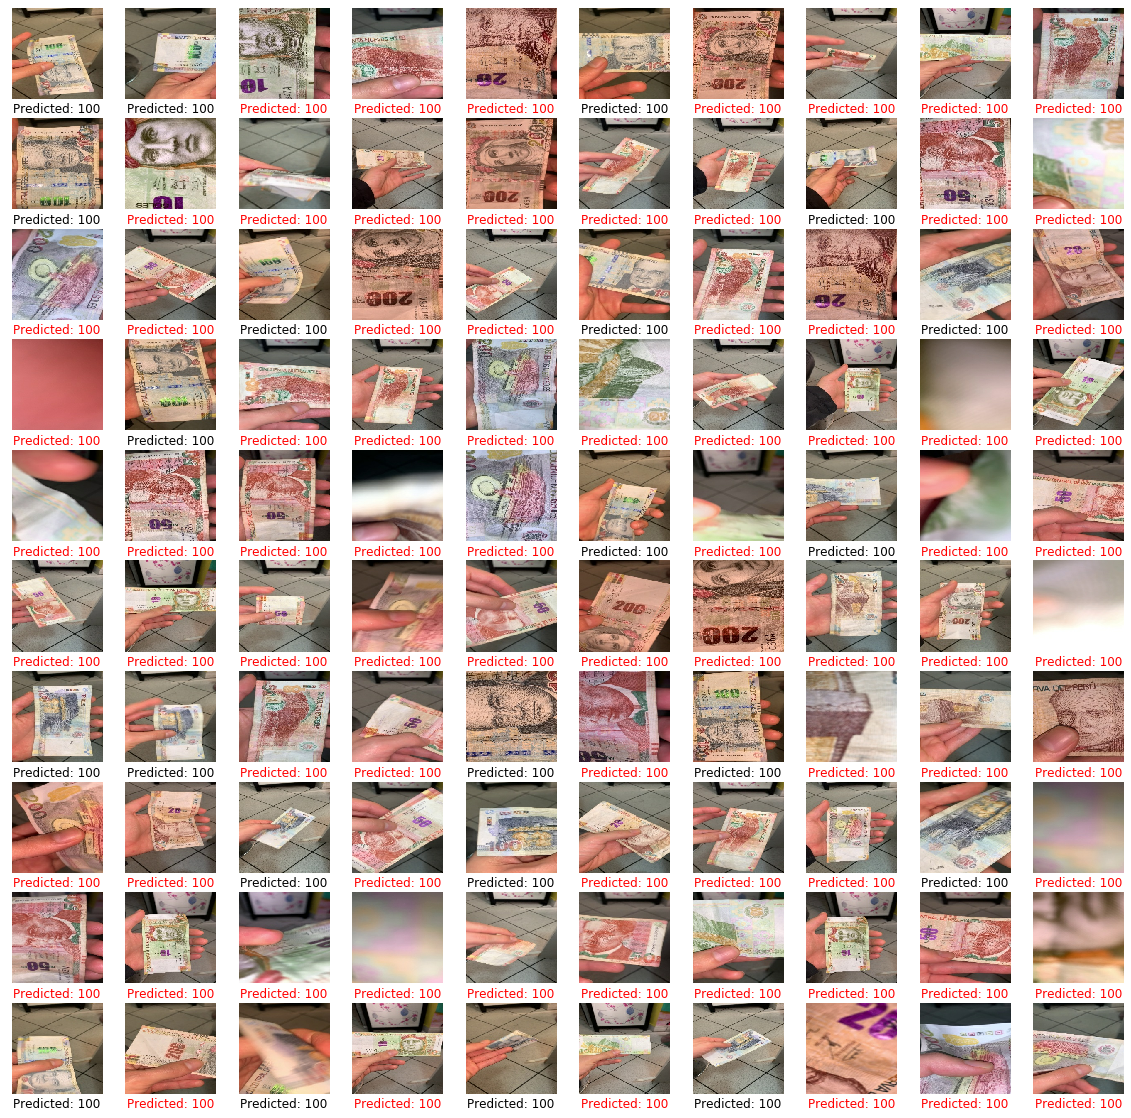

In [27]:
test_data = ImageClassifierDataLoader.from_folder(path_validation)

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)

    swapped = np.moveaxis(image, 0, 1)
    arr4d = np.expand_dims(swapped, 0)
    
    #utilizando el average de los modelos para la predicción
    predictions = []
    for model in models:
        predictions.append(model.predict(arr4d))
    id_predict = np.argmax(np.average(predictions))
    
    predict_label = "100"
    if id_predict == 1:
        predict_label = "20"
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    #color = 'black'
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()